In [1]:
from pylab import *
import os 
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision as tv
import torchvision.transforms as transforms
from PIL import Image
from collections import OrderedDict
import torch.utils.data as td
from vgg import VGG

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### data loading

In [2]:
# define gram matrix
class gram_matrix(nn.Module):
    def forward(self, input):
        a, b, c, d = input.size()  
        features = input.view(a * b, c * d)  
        G = torch.mm(features, features.t())  
        gramMatrix = G.div(a * b * c * d)
        return gramMatrix

# defining gram loss
class gram_loss(nn.Module):
    def forward(self, input, target):
        result = nn.MSELoss()(gram_matrix()(input), target)
        return(result)

In [3]:
# process image
img_size = 256
pre_process = tv.transforms.Compose([tv.transforms.Resize([img_size, img_size]),
                           tv.transforms.ToTensor(),
                           tv.transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # turn channels into BGR
                           tv.transforms.Normalize([0.5,0.5,0.5], [1,1,1]), # normalization
                           tv.transforms.Lambda(lambda x: x.mul_(255)),
                          ])
image_rec = tv.transforms.Compose([tv.transforms.Lambda(lambda x: x.mul_(1./255)),
                           tv.transforms.Normalize([-0.5,-0.5,-0.5], [1,1,1]), # normalization
                           tv.transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), # turn channels into RGB
                           ])
toPIL = tv.transforms.Compose([transforms.ToPILImage()])

def image_process(img_tensor): # to transferred results in the range [0,1]
    vals = image_rec(img_tensor)
    vals[ vals > 1 ] = 1    
    vals[ vals < 0 ] = 0
    img = toPIL(vals)
    return img

In [4]:
# load network
net = VGG()
net.load_state_dict(torch.load(os.getcwd() + '/Models/vgg_conv.pth'))

for param in net.parameters():
    param.requires_grad = False

net.to(device)

VGG(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_1): Conv2d(512, 512,

In [5]:
style_file_name = 'wave'
content_file_name = 'touchfish'
style_image_dir = os.getcwd() + '/images/style_image/' + style_file_name + '.jpg'
content_image_dir = os.getcwd() + '/images/content_image/' + content_file_name + '.jpg'

style_image = pre_process(Image.open(style_image_dir)).unsqueeze(0).to(device)
content_image = pre_process(Image.open(content_image_dir)).unsqueeze(0).to(device)
input_image = Variable(content_image.data.clone(), requires_grad=True)

In [6]:
# define style and content layers
style_layers = ['relu11','relu21','relu31','relu41', 'relu51'] 
content_layers = ['relu42']
style_layesr_len = len(style_layers)
content_layers_len = len(content_layers)
loss_layers = style_layers + content_layers

# defining style and content loss functions
loss_functions = [gram_loss().to(device)] * style_layesr_len + [nn.MSELoss().to(device)] * content_layers_len 

# defining style and content weight
style_weights = [10000e1/n**2 for n in [64,128,256,512,512]]
content_weights = [1]
total_weights = style_weights + content_weights

# defining optimization targets
style_target = [gram_matrix()(style_feature).detach() for style_feature in net(style_image, style_layers)]
content_target = [content_feature.detach() for content_feature in net(content_image, content_layers)]
all_targets = style_target + content_target

In [7]:
def get_optimizer(input_image):
    optimizer = optim.LBFGS([input_image.requires_grad_()]) # gradient needed
    return optimizer

Start to transfer...


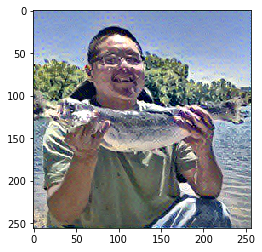

In [8]:
# start style transfer here
total_iterations = 200
optimizer = get_optimizer(input_image);
print('Start to transfer...')
num_iter = [0]
while num_iter[0] <= total_iterations:
    def closure():
        optimizer.zero_grad()
        output = net(input_image, loss_layers)
        layer_losses = [total_weights[key] * loss_functions[key](entry, all_targets[key]) for key, entry in enumerate(output)]
        loss = sum(layer_losses)
        loss.backward()
        num_iter[0] = num_iter[0] + 1
        return loss    
    optimizer.step(closure)
    
# show tranferred rimage
output_image = image_process(input_image.data[0].cpu().squeeze())
imshow(output_image)